<a href="https://colab.research.google.com/github/dinesh110598/Ising_DNN/blob/main/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 2D Square FM Ising model simulation

Importing required libraries:

In [ ]:
import numpy as np
from tensorflow import keras as tfk
import tensorflow as tf
from numba import cuda,jit
import cupy as cp
import matplotlib.pyplot as plt

In [ ]:
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-063e0c92-6b75-cfeb-fa99-45b7c9ca4b0d)


Uploading the script files containing CUDA kernels that help quickly simulate the Ising model:

In [ ]:
!curl -o Ising_kernels.py https://raw.githubusercontent.com/dinesh110598/Ising_DNN/main/Ising_kernels.py

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5472  100  5472    0     0  44129      0 --:--:-- --:--:-- --:--:-- 44129


In [ ]:
from Ising_kernels import *

## Training Data generation
Let's write a function that generates training data for either ferromagnetic or paramagnetic phase using the imported kernels:

In [ ]:
def generate_train_data (train_len, phase="FM",
                         lat_len=72, m=100):
    shape = (lat_len, lat_len)
    n_ens = train_len//m
    spin = cp.ones ((train_len,)+shape, np.int8)
    seed = cp.random.randint (-10000,10000, size=(train_len,)+shape,
                                       dtype=np.int32)
    J = cp.asarray (np.float32(-1.)) #This is for FM Ising model
    tpb = (1,8,8)
    bpg = (train_len, lat_len//8, lat_len//8)
    if phase == "FM":
        T = cp.random.uniform (0.5, 2.2, (n_ens,m),
                                  np.float32)
    elif phase == "AFM":
        T = cp.random.uniform (2.3, 4.5, (n_ens,m),
                                  np.float32)
    for _ in range (1000):
        update_black[bpg,tpb] (spin, seed, T, J)
        update_white[bpg,tpb] (spin, seed, T, J)

    spin = 0.5*cp.asnumpy (spin)
    avgs = np.sign(np.mean (spin, axis=(1,2)))
    avgs = avgs [...,np.newaxis]
    avgs = avgs [...,np.newaxis]
    spin = avgs*spin
    return spin.astype(np.float32)

Generating training data of size 6000 for each phase:

In [ ]:
t_lattice = generate_train_data (6000, "FM")
t_label = np.ones (6000, np.int32)
t_lattice = np.concatenate ([t_lattice, generate_train_data (6000,"AFM")])
t_label = np.concatenate ([t_label, np.zeros (6000, np.int32)])

Let's put everything inside a dataset and shuffle them:

In [ ]:
train_data = tf.data.Dataset.from_tensor_slices ((t_lattice, t_label))
train_data = train_data.shuffle (12000)

Let's split this up into training and validation data:

In [ ]:
val_data = train_data.take (2000)
train_data = train_data.skip (2000)

In [ ]:
val_data = val_data.batch (1)
train_data = train_data.batch (1)

## Neural network initialization and training

In [ ]:
model = tfk.Sequential ([
            tfk.layers.Flatten (),
            tfk.layers.Dense (100, activation="sigmoid"),
            tfk.layers.Dense (2, activation="softmax")
])

Note on model architecture: We did not use l2 regularizer as suggested in [this](http://dx.doi.org/10.1038/nphys4035) paper since that's needed only when training data is not sufficient. Let's compile and train the model:

In [ ]:
model.compile (optimizer="adam", 
               loss= "sparse_categorical_crossentropy",
               metrics= ['accuracy'])

In [ ]:
hist = model.fit (train_data, epochs=1,
                  validation_data= val_data)

10000/10000 [==============================] - 23s 2ms/step - loss: 0.0591 - accuracy: 0.9790 - val_loss: 0.0135 - val_accuracy: 0.9970


We have achieved 99.7% accuracy on the validation data (which is effectively just test data since we ran 1 epoch). We'll save the model before proceeding:

In [ ]:
model.save ("FM_Ising_NN")

INFO:tensorflow:Assets written to: FM_Ising_NN/assets


## Magnetization and Output layer data:

We'll write a function that generates temperature wise data of FM Ising lattices to observe neural network output along with magnetization:

In [ ]:
def temp_wise_data (low=0.5, high=4.5, step=0.1,
                    lat_len=72, m=100):
    train_len = math.ceil ((high-low)*m/step)
    shape = (lat_len, lat_len)
    n_ens = math.ceil ((high-low)/step)
    spin = cp.ones ((train_len,)+shape, np.int8)
    seed = cp.random.randint (-10000,10000, size=(train_len,)+shape,
                                       dtype=np.int32)
    J = cp.asarray (np.float32(-1.)) #This is for FM Ising model
    tpb = (1,8,8)
    bpg = (train_len, lat_len//8, lat_len//8)
    T = cp.arange (low, high, step, np.float32)
    T = cp.expand_dims (T, 1)
    T = cp.broadcast_to (T, (n_ens, m))
    for _ in range (1000):
        update_black[bpg,tpb] (spin, seed, T, J)
        update_white[bpg,tpb] (spin, seed, T, J)

    spin = 0.5*cp.asnumpy (spin)
    avgs = np.sign(np.mean (spin, axis=(1,2)))
    avgs = avgs [...,np.newaxis]
    avgs = avgs [...,np.newaxis]
    spin = avgs*spin
    return spin.astype(np.float32)

In [ ]:
t_lattice = temp_wise_data (1.0, 4.0, 0.1)

Plotting graphs for magnetization and neural network output:

In [ ]:
mag = np.mean (2*t_lattice, axis= (1,2))
mag_data = []
neural_data = []
pred = model.predict (t_lattice)
datax = np.arange (1.0, 4.0 ,0.1)
for i in range (len(datax)):
    mag_data.append (mag[i*100: (i+1)*100].mean())
    neural_data.append (pred[i*100:(i+1)*100, 1].mean())

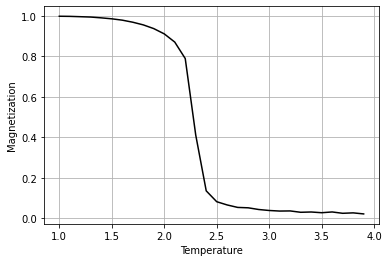

In [ ]:
plt.plot (datax, mag_data, color='black')
plt.grid()
plt.xlabel ("Temperature")
plt.ylabel ("Magnetization")
plt.show()

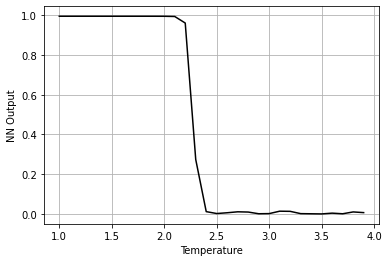

In [ ]:
plt.plot (datax, neural_data, color='black')
plt.grid()
plt.xlabel ("Temperature")
plt.ylabel ("NN Output")
plt.show()

# 2D Triangular FM Ising Model Simulation

In [ ]:
import numpy as np
from tensorflow import keras as tfk
import tensorflow as tf
from numba import cuda,jit
import cupy as cp
import matplotlib.pyplot as plt

In [ ]:
!curl -o Ising_kernels.py https://raw.githubusercontent.com/dinesh110598/Ising_DNN/main/Ising_kernels.py

In [ ]:
from Ising_kernels import *

We aren't defining and training any neural network here, but rather using the network trained on the square FM Ising model to make predictions.

## Magnetization and Output Layer data

In [ ]:
def temp_wise_data (low=1.5, high=5.0, step=0.1,
                    lat_len=72, m=100):
    train_len = math.ceil ((high-low)*m/step)
    shape = (lat_len, lat_len)
    n_ens = math.ceil ((high-low)/step)
    spin = cp.ones ((train_len,)+shape, np.int8)
    seed = cp.random.randint (-10000,10000, size=(train_len,)+shape,
                                       dtype=np.int32)
    J = cp.asarray (np.float32(-1.)) #This is for FM Ising model
    tpb = (1,8,8)
    bpg = (train_len, lat_len//8, lat_len//8)
    T = cp.arange (low, high, step, np.float32)
    T = cp.expand_dims (T, 1)
    T = cp.broadcast_to (T, (n_ens, m))
    for _ in range (1000):
        update_red[bpg,tpb] (spin, seed, T, J)
        update_blue[bpg,tpb] (spin, seed, T, J)
        update_green[bpg,tpb] (spin, seed, T, J)

    spin = 0.5*cp.asnumpy (spin)
    avgs = np.sign(np.mean (spin, axis=(1,2)))
    avgs = avgs [...,np.newaxis]
    avgs = avgs [...,np.newaxis]
    spin = avgs*spin
    return spin.astype(np.float32)

In [ ]:
t_lattice = temp_wise_data (2.0, 5.5, 0.1)

In [ ]:
mag = np.mean (2*t_lattice, axis= (1,2))
mag_data = []
neural_data = []
pred = model.predict (t_lattice)
datax = np.arange (2.0, 5.5 ,0.1)
for i in range (len(datax)):
    mag_data.append (mag[i*100: (i+1)*100].mean())
    neural_data.append (pred[i*100:(i+1)*100, 1].mean())

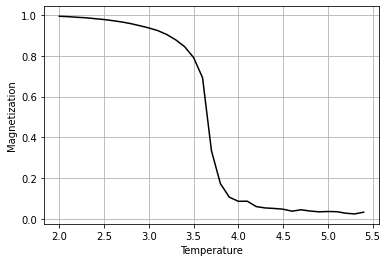

In [ ]:
plt.plot (datax, mag_data, color='black')
plt.grid()
plt.xlabel ("Temperature")
plt.ylabel ("Magnetization")
plt.show()

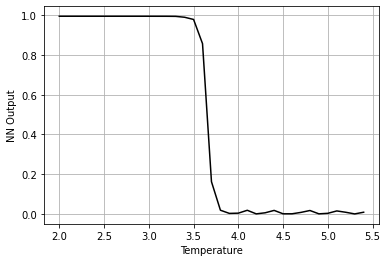

In [ ]:
plt.plot (datax, neural_data, color='black')
plt.grid()
plt.xlabel ("Temperature")
plt.ylabel ("NN Output")
plt.show()

# 2D Square AFM Ising model Simulation

In [ ]:
import numpy as np
from tensorflow import keras as tfk
import tensorflow as tf
from numba import cuda,jit
import cupy as cp
import matplotlib.pyplot as plt

In [ ]:
!curl -o Ising_kernels.py https://raw.githubusercontent.com/dinesh110598/Ising_DNN/main/Ising_kernels.py

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  7160  100  7160    0     0  57741      0 --:--:-- --:--:-- --:--:-- 57741


In [ ]:
from Ising_kernels import *

Let's load the saved neural network model:

In [ ]:
!apt-get install subversion

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following additional packages will be installed:
  libapr1 libaprutil1 libserf-1-1 libsvn1
Suggested packages:
  db5.3-util libapache2-mod-svn subversion-tools
The following NEW packages will be installed:
  libapr1 libaprutil1 libserf-1-1 libsvn1 subversion
0 upgraded, 5 newly installed, 0 to remove and 15 not upgraded.
Need to get 2,237 kB of archives.
After this operation, 9,910 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/main amd64 libapr1 amd64 1.6.3-2 [90.9 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic/main amd64 libaprutil1 amd64 1.6.1-2 [84.4 kB]
Get:3 http://archive.ubuntu.com/ubuntu bionic/universe amd64 libserf-1-1 amd64 1.3.9-6 [44.4 kB]
Get:4 http://archive.ubuntu.com/ubuntu bionic/universe amd64 libsvn1 amd64 1.9.7-4ubuntu1 [1,183 kB]
Get:5 http://archive.ubuntu.com/ubuntu bionic/universe amd64 subversion amd64 1.9.7-4ubuntu1 

In [ ]:
!svn checkout https://github.com/dinesh110598/Ising_DNN/trunk/FM_Ising_NN

A    FM_Ising_NN/saved_model.pb
A    FM_Ising_NN/variables
A    FM_Ising_NN/variables/variables.data-00000-of-00001
A    FM_Ising_NN/variables/variables.index
Checked out revision 12.


In [ ]:
model = tfk.models.load_model ("FM_Ising_NN")

## Magnetization and Output layer data

We'll use a similar data generating function but set lattice length as 144 so that we can look at magnetization and apply the neural network on even positions:

In [ ]:
def temp_wise_data (low=1.5, high=5.0, step=0.1,
                    lat_len=144, m=100):
    @cuda.jit
    def write_spin (spin, even_spin):
        z,x,y = cuda.grid (3)
        if x%2==0 and y%2==0:
            even_spin[z,x//2,y//2] = spin[z,x,y]

    train_len = math.ceil ((high-low)*m/step)
    shape = (lat_len, lat_len)
    n_ens = math.ceil ((high-low)/step)
    spin = cp.ones ((train_len,)+shape, np.int8)
    seed = cp.random.randint (-10000,10000, size=(train_len,)+shape,
                                       dtype=np.int32)
    J = cp.asarray (np.float32(1.)) #This is for AFM Ising model
    tpb = (1,8,8)
    bpg = (train_len, lat_len//8, lat_len//8)
    T = cp.arange (low, high, step, np.float32)
    T = cp.expand_dims (T, 1)
    T = cp.broadcast_to (T, (n_ens, m))
    for _ in range (1000):
        update_black[bpg,tpb] (spin, seed, T, J)
        update_white[bpg,tpb] (spin, seed, T, J)

    even_spin = cp.empty ((train_len, lat_len//2, lat_len//2))
    write_spin[bpg,tpb] (spin, even_spin)
    spin = 0.5*cp.asnumpy (even_spin)
    avgs = np.sign(np.mean (spin, axis=(1,2)))
    avgs = avgs [...,np.newaxis]
    avgs = avgs [...,np.newaxis]
    spin = avgs*spin
    return spin.astype(np.float32)

In [ ]:
t_lattice = temp_wise_data (0.5, 4.0, 0.1)

In [ ]:
t_lattice.shape

(3500, 72, 72)

In [ ]:
mag = np.mean (2*t_lattice, axis= (1,2))
mag_data = []
neural_data = []
pred = model.predict (t_lattice)
datax = np.arange (0.5, 4.0 ,0.1)
for i in range (len(datax)):
    mag_data.append (mag[i*100: (i+1)*100].mean())
    neural_data.append (pred[i*100:(i+1)*100, 1].mean())

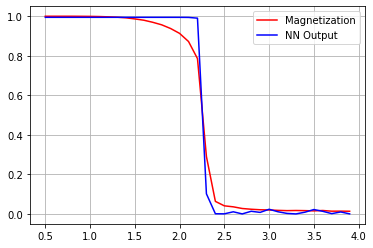

In [ ]:
fig, ax = plt.subplots ()
ax.plot (datax, mag_data, color='red', label='Magnetization')
ax.plot (datax, neural_data, color='blue', label='NN Output')
ax.legend()
ax.grid ()
plt.show()

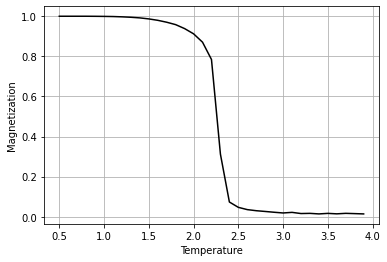

In [ ]:
plt.plot (datax, mag_data, color='black')
plt.grid()
plt.xlabel ("Temperature")
plt.ylabel ("Magnetization")
plt.show()

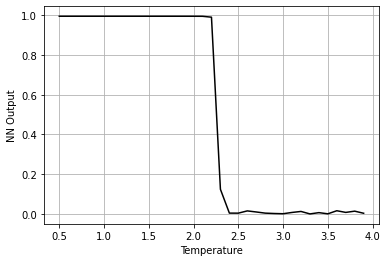

In [ ]:
plt.plot (datax, neural_data, color='black')
plt.grid()
plt.xlabel ("Temperature")
plt.ylabel ("NN Output")
plt.show()

## ...with external field

When there's an external field, the Hamiltonian for 2D Square Ising model becomes:
$$ H = J\displaystyle\sum_{i,j=1}^L (S_{i,j} S_{i+1,j} + S_{i,j}S_{i,j+1}) - h\displaystyle\sum_{i,j=1}^L S_{i,j}$$ where we set $J=1$ for AFM model and put $h=0$ so far. We'll set h to values categorically above or below 4 and look at magnetization/neural network output for each of these cases.

### h=3
We'll set L=72 and look at the entire lattice (not even positions alone) since we expect to have non zero magnetizations at various temperatures:

In [ ]:
def temp_wise_data (low=0.5, high=4.0, step=0.1, h=3.0,
                    lat_len=72, m=100):

    train_len = math.ceil ((high-low)*m/step)
    shape = (lat_len, lat_len)
    n_ens = math.ceil ((high-low)/step)
    spin = cp.ones ((train_len,)+shape, np.int8)
    seed = cp.random.randint (-10000,10000, size=(train_len,)+shape,
                                       dtype=np.int32)
    J = cp.asarray (np.float32(1.)) #This is for AFM Ising model
    h = cp.asarray (np.float32(h)) #Value of external field
    tpb = (1,8,8)
    bpg = (train_len, lat_len//8, lat_len//8)
    T = cp.arange (low, high, step, np.float32)
    T = cp.expand_dims (T, 1)
    T = cp.broadcast_to (T, (n_ens, m))
    for _ in range (1000):
        update_black_ext[bpg,tpb] (spin, seed, T, J, h)
        update_white_ext[bpg,tpb] (spin, seed, T, J, h)

    spin = 0.5*cp.asnumpy (spin)
    avgs = np.sign(np.mean (spin, axis=(1,2)))
    avgs = avgs [...,np.newaxis]
    avgs = avgs [...,np.newaxis]
    spin = avgs*spin
    return spin.astype(np.float32)

In [ ]:
m = 800
t_lattice = temp_wise_data (m= m)

In [ ]:
mag = np.mean (2*t_lattice, axis= (1,2))
mag_data = []
neural_data = []
pred = model.predict (t_lattice)
datax = np.arange (0.5, 4.0 ,0.1)
for i in range (len(datax)):
    mag_data.append (mag[i*m: (i+1)*m].mean())
    neural_data.append (pred[i*m:(i+1)*m, 1].mean())

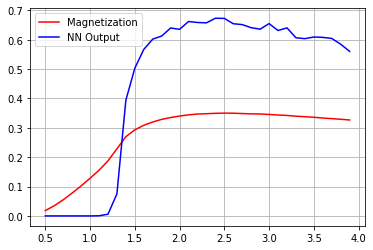

In [ ]:
fig, ax = plt.subplots ()
ax.plot (datax, mag_data, color='red', label='Magnetization')
ax.plot (datax, neural_data, color='blue', label='NN Output')
ax.legend()
ax.grid ()
plt.show()

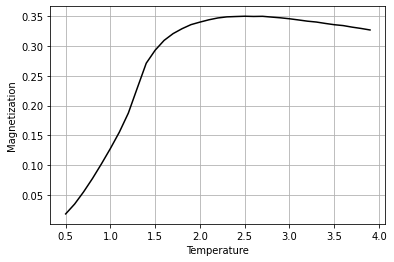

In [ ]:
plt.plot (datax, mag_data, color='black')
plt.grid()
plt.xlabel ("Temperature")
plt.ylabel ("Magnetization")
plt.show()

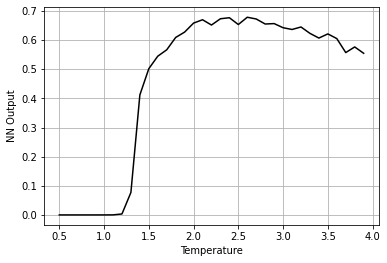

In [ ]:
plt.plot (datax, neural_data, color='black')
plt.grid()
plt.xlabel ("Temperature")
plt.ylabel ("NN Output")
plt.show()

The noise in the above graph seems to reduce, the more samples we average over for each temperature point. Moreover, there could be some intrinsic noise due to any imperfections in the neural network's training.

Now, we'll look at the even spins alone for a lattice of 2x larger length

In [ ]:
def temp_wise_data (low=0.5, high=4.0, step=0.1, h=3.0,
                    lat_len=144, m=100):
    @cuda.jit
    def write_spin (spin, even_spin):
        z,x,y = cuda.grid (3)
        if x%2==0 and y%2==0:
            even_spin[z,x//2,y//2] = spin[z,x,y]

    train_len = math.ceil ((high-low)*m/step)
    shape = (lat_len, lat_len)
    n_ens = math.ceil ((high-low)/step)
    spin = cp.ones ((train_len,)+shape, np.int8)
    seed = cp.random.randint (-10000,10000, size=(train_len,)+shape,
                                       dtype=np.int32)
    J = cp.asarray (np.float32(1.)) #This is for AFM Ising model
    h = cp.asarray (np.float32(h)) #Value of external field
    tpb = (1,8,8)
    bpg = (train_len, lat_len//8, lat_len//8)
    T = cp.arange (low, high, step, np.float32)
    T = cp.expand_dims (T, 1)
    T = cp.broadcast_to (T, (n_ens, m))
    for _ in range (1000):
        update_black_ext[bpg,tpb] (spin, seed, T, J, h)
        update_white_ext[bpg,tpb] (spin, seed, T, J, h)

    even_spin = cp.empty ((train_len, lat_len//2, lat_len//2))
    write_spin[bpg,tpb] (spin, even_spin)
    spin = 0.5*cp.asnumpy (even_spin)
    avgs = np.sign(np.mean (spin, axis=(1,2)))
    avgs = avgs [...,np.newaxis]
    avgs = avgs [...,np.newaxis]
    spin = avgs*spin
    return spin.astype(np.float32)

In [ ]:
m=500
t_lattice = temp_wise_data (m= m)

In [ ]:
mag = np.mean (2*t_lattice, axis= (1,2))
mag_data = []
neural_data = []
pred = model.predict (t_lattice)
datax = np.arange (0.5, 4.0 ,0.1)
for i in range (len(datax)):
    mag_data.append (mag[i*m: (i+1)*m].mean())
    neural_data.append (pred[i*m:(i+1)*m, 1].mean())

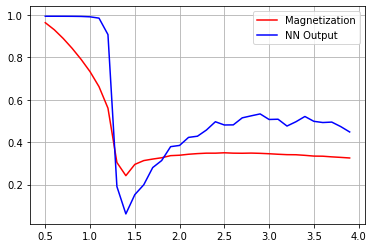

In [ ]:
fig, ax = plt.subplots ()
ax.plot (datax, mag_data, color='red', label='Magnetization')
ax.plot (datax, neural_data, color='blue', label='NN Output')
ax.legend()
ax.grid ()
plt.show()

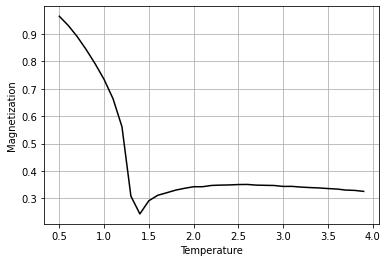

In [ ]:
plt.plot (datax, mag_data, color='black')
plt.grid()
plt.xlabel ("Temperature")
plt.ylabel ("Magnetization")
plt.show ()

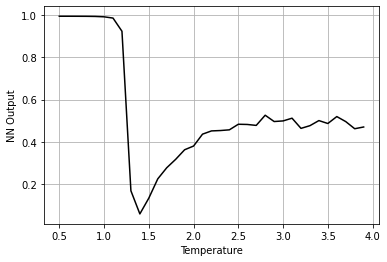

In [ ]:
plt.plot (datax, neural_data, color='black')
plt.grid()
plt.xlabel ("Temperature")
plt.ylabel ("NN Output")
plt.show()

### h=4.5
We'll set L=72 and look at the entire lattice (not even positions alone) since we expect to have non zero magnetizations at various temperatures:

In [ ]:
def temp_wise_data (low=0.5, high=4.0, step=0.1, h=4.5,
                    lat_len=72, m=100):

    train_len = math.ceil ((high-low)*m/step)
    shape = (lat_len, lat_len)
    n_ens = math.ceil ((high-low)/step)
    spin = cp.ones ((train_len,)+shape, np.int8)
    seed = cp.random.randint (-10000,10000, size=(train_len,)+shape,
                                       dtype=np.int32)
    J = cp.asarray (np.float32(1.)) #This is for AFM Ising model
    h = cp.asarray (np.float32(h)) #Value of external field
    tpb = (1,8,8)
    bpg = (train_len, lat_len//8, lat_len//8)
    T = cp.arange (low, high, step, np.float32)
    T = cp.expand_dims (T, 1)
    T = cp.broadcast_to (T, (n_ens, m))
    for _ in range (1000):
        update_black_ext[bpg,tpb] (spin, seed, T, J, h)
        update_white_ext[bpg,tpb] (spin, seed, T, J, h)

    spin = 0.5*cp.asnumpy (spin)
    avgs = np.sign(np.mean (spin, axis=(1,2)))
    avgs = avgs [...,np.newaxis]
    avgs = avgs [...,np.newaxis]
    spin = avgs*spin
    return spin.astype(np.float32)

In [ ]:
m = 1000
t_lattice = temp_wise_data (m= m)

In [ ]:
mag = np.mean (2*t_lattice, axis= (1,2))
mag_data = []
neural_data = []
pred = model.predict (t_lattice)
datax = np.arange (0.5, 4.0 ,0.1)
for i in range (len(datax)):
    mag_data.append (mag[i*m: (i+1)*m].mean())
    neural_data.append (pred[i*m:(i+1)*m, 1].mean())

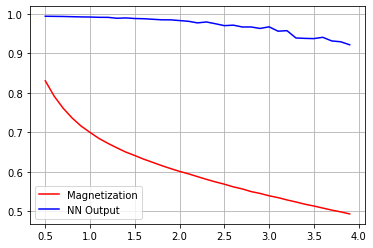

In [ ]:
fig, ax = plt.subplots ()
ax.plot (datax, mag_data, color='red', label='Magnetization')
ax.plot (datax, neural_data, color='blue', label='NN Output')
ax.legend()
ax.grid ()
plt.show()

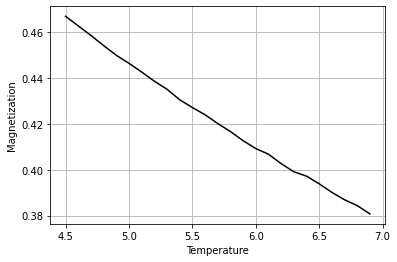

In [ ]:
plt.plot (datax, mag_data, color='black')
plt.grid()
plt.xlabel ("Temperature")
plt.ylabel ("Magnetization")
plt.show()

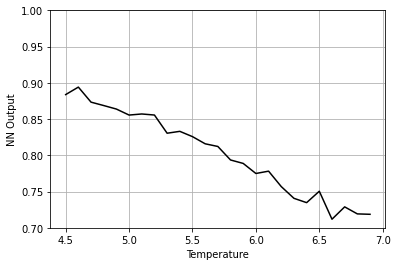

In [ ]:
plt.plot (datax, neural_data, color='black')
plt.grid()
plt.xlabel ("Temperature")
plt.ylabel ("NN Output")
plt.ylim (0.7,1.0)
plt.show()

The noise in the above graph seems to reduce, the more samples we average over for each temperature point. Moreover, there could be some intrinsic noise due to any imperfections in the neural network's training.

Now, we'll look at the even spins alone for a lattice of 2x larger length

In [ ]:
def temp_wise_data (low=0.5, high=4.0, step=0.1, h=4.5,
                    lat_len=144, m=100):
    @cuda.jit
    def write_spin (spin, even_spin):
        z,x,y = cuda.grid (3)
        if x%2==0 and y%2==0:
            even_spin[z,x//2,y//2] = spin[z,x,y]

    train_len = math.ceil ((high-low)*m/step)
    shape = (lat_len, lat_len)
    n_ens = math.ceil ((high-low)/step)
    spin = cp.ones ((train_len,)+shape, np.int8)
    seed = cp.random.randint (-10000,10000, size=(train_len,)+shape,
                                       dtype=np.int32)
    J = cp.asarray (np.float32(1.)) #This is for AFM Ising model
    h = cp.asarray (np.float32(h)) #Value of external field
    tpb = (1,8,8)
    bpg = (train_len, lat_len//8, lat_len//8)
    T = cp.arange (low, high, step, np.float32)
    T = cp.expand_dims (T, 1)
    T = cp.broadcast_to (T, (n_ens, m))
    for _ in range (1000):
        update_black_ext[bpg,tpb] (spin, seed, T, J, h)
        update_white_ext[bpg,tpb] (spin, seed, T, J, h)

    even_spin = cp.empty ((train_len, lat_len//2, lat_len//2))
    write_spin[bpg,tpb] (spin, even_spin)
    spin = 0.5*cp.asnumpy (even_spin)
    avgs = np.sign(np.mean (spin, axis=(1,2)))
    avgs = avgs [...,np.newaxis]
    avgs = avgs [...,np.newaxis]
    spin = avgs*spin
    return spin.astype(np.float32)

In [ ]:
m=800
t_lattice = temp_wise_data (m= m)

In [ ]:
mag = np.mean (2*t_lattice, axis= (1,2))
mag_data = []
neural_data = []
pred = model.predict (t_lattice)
datax = np.arange (0.5, 4.0 ,0.1)
for i in range (len(datax)):
    mag_data.append (mag[i*m: (i+1)*m].mean())
    neural_data.append (pred[i*m:(i+1)*m, 1].mean())

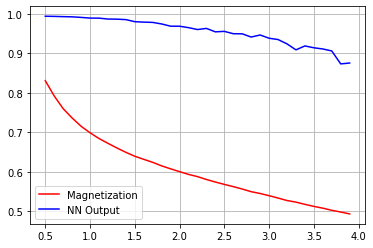

In [ ]:
fig, ax = plt.subplots ()
ax.plot (datax, mag_data, color='red', label='Magnetization')
ax.plot (datax, neural_data, color='blue', label='NN Output')
ax.legend()
ax.grid ()
plt.show()

In [ ]:
from google.colab import output
output.eval_js('new Audio("https://upload.wikimedia.org/wikipedia/commons/0/05/Beep-09.ogg").play()')

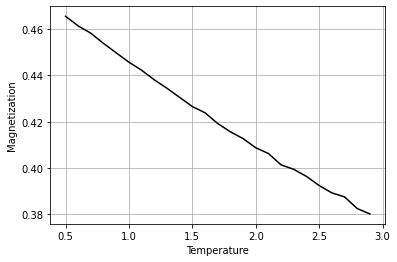

In [ ]:
plt.plot (datax, mag_data, color='black')
plt.grid()
plt.xlabel ("Temperature")
plt.ylabel ("Magnetization")
plt.show()

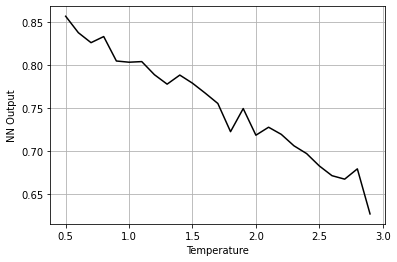

In [ ]:
plt.plot (datax, neural_data, color='black')
plt.grid()
plt.xlabel ("Temperature")
plt.ylabel ("NN Output")
plt.show()